# Custom Object and Scene detection using Amazon Rekognition Custom Labels API

***

In [1]:
!pip install botocore --upgrade
!pip install boto3 --upgrade

     |████████████████████████████████| 8.6 MB 16.0 MB/s            
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.12
    Uninstalling botocore-1.24.12:
      Successfully uninstalled botocore-1.24.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.22.67 requires botocore==1.24.12, but you have botocore 1.24.23 which is incompatible.
aiobotocore 1.3.0 requires botocore<1.20.50,>=1.20.49, but you have botocore 1.24.23 which is incompatible.
     |████████████████████████████████| 132 kB 15.7 MB/s            
  Attempting uninstall: boto3
    Found existing installation: boto3 1.21.12
    Uninstalling boto3-1.21.12:
      Successfully uninstalled boto3-1.21.12


In [3]:
# Initialize Notebook

import json
import xml.etree.ElementTree as ET
from datetime import datetime
from os import listdir, makedirs
from os.path import isfile, join
import shutil

import boto3
from IPython.display import HTML, display, Image as IImage
from PIL import Image, ImageDraw, ImageFont
import time
import os

from IPython.display import JSON

In [4]:
session = boto3.session.Session()
region = session.region_name

print("AWS Region: ", region)

AWS Region:  ap-northeast-2


In [5]:
# init clients
rekognition = boto3.client('rekognition')
s3_client = boto3.client('s3')

In [6]:
# s3 bucket name: custom-labels-console-ap-northeast-2-848d0c39c9
rek_cl_default_bucket = 'custom-labels-console-ap-northeast-2-848d0c39c9'

***

## Download the Public Stanford Dog Datasets

### Dataset and Annotation dataset url

In [7]:
stanford_dog_dataset_image_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
stanford_dog_dataset_annotation_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar"

### Creating directories in the current location

In [8]:
!mkdir -p ./stanford_dog_dataset/images_tar
!mkdir -p ./stanford_dog_dataset/images
!mkdir -p ./stanford_dog_dataset/annotation_tar
!mkdir -p ./stanford_dog_dataset/annotation

### Download the dataset to the directories created above

In [9]:
!curl $stanford_dog_dataset_image_url --output ./stanford_dog_dataset/images_tar/images.tar
!curl $stanford_dog_dataset_annotation_url --output ./stanford_dog_dataset/annotation_tar/annotation.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  756M  100  756M    0     0  10.3M      0  0:01:13  0:01:13 --:--:-- 10.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20.8M  100 20.8M    0     0  3346k      0  0:00:06  0:00:06 --:--:-- 4434k


### Unzipping the downloaded datasets

In [10]:
!tar -xf ./stanford_dog_dataset/images_tar/images.tar -C ./stanford_dog_dataset/images
!tar -xf ./stanford_dog_dataset/annotation_tar/annotation.tar -C ./stanford_dog_dataset/annotation

***

## EDA for Dog Breed Identification Dataset

In [12]:
import numpy as np
import pandas as pd

In [14]:
image_path_list = []

for dirname, _, filenames in os.walk('./stanford_dog_dataset/images/Images'):
    for filename in filenames:
        print('image_file_path: ', os.path.join(dirname, filename))
        image_path_list.append(os.path.join(dirname, filename))

image_file_path:  ./stanford_dog_dataset/images/Images/n02097298-Scotch_terrier/n02097298_2671.jpg
image_file_path:  ./stanford_dog_dataset/images/Images/n02097298-Scotch_terrier/n02097298_3611.jpg
image_file_path:  ./stanford_dog_dataset/images/Images/n02097298-Scotch_terrier/n02097298_1152.jpg
image_file_path:  ./stanford_dog_dataset/images/Images/n02097298-Scotch_terrier/n02097298_65.jpg
image_file_path:  ./stanford_dog_dataset/images/Images/n02097298-Scotch_terrier/n02097298_2492.jpg
image_file_path:  ./stanford_dog_dataset/images/Images/n02097298-Scotch_terrier/n02097298_8974.jpg
image_file_path:  ./stanford_dog_dataset/images/Images/n02097298-Scotch_terrier/n02097298_8452.jpg
image_file_path:  ./stanford_dog_dataset/images/Images/n02097298-Scotch_terrier/n02097298_2583.jpg
image_file_path:  ./stanford_dog_dataset/images/Images/n02097298-Scotch_terrier/n02097298_825.jpg
image_file_path:  ./stanford_dog_dataset/images/Images/n02097298-Scotch_terrier/n02097298_2279.jpg
image_file_pa

In [15]:
print("Image count: ", len(image_path_list))

Image count:  20580


In [19]:
start_idx = './stanford_dog_dataset/images/Images/n02097298-Scotch_terrier/n02097298_2671.jpg'.find('/', 30)
print("Image Label start index: ", start_idx)

end_idx = './stanford_dog_dataset/images/Images/n02097298-Scotch_terrier/n02097298_2671.jpg'.rfind('/')
print("Image Label end index: ", end_idx)

image_label = './stanford_dog_dataset/images/Images/n02097298-Scotch_terrier/n02097298_2671.jpg'[start_idx+1:end_idx]
print("Image Label: ", image_label)

image_label_name = image_label[image_label.find('-')+1:]
print("Image Label Name: ", image_label_name)

Image Label start index:  36
Image Label end index:  61
Image Label:  n02097298-Scotch_terrier
Image Label Name:  Scotch_terrier


### Make Dog Breed Dataframe Function

In [32]:
image_dir = './stanford_dog_dataset/images/Images'

In [35]:
def make_dogbreed_dataframe(image_dir=image_dir):
    paths = []
    labels = []
    
    for dirname, _, filenames in os.walk(image_dir):
        for filename in filenames:
            if '.jpg' in filename:
                file_path = dirname + '/' + filename
                paths.append(file_path)
                start_idx = file_path.find('/', 30)
                end_idx = file_path.rfind('/')
                image_label = file_path[start_idx+1:end_idx]
                image_label_name = image_label[image_label.find('-')+1:]
                labels.append(image_label_name)
    
    data_df = pd.DataFrame(
        {
            'path': paths,
            'label': labels
        }
    )
    
    return data_df

In [36]:
pd.set_option('display.max_colwidth', 200)

data_df = make_dogbreed_dataframe()
print("data_df shape: ", data_df.shape)

data_df shape:  (20580, 2)


In [37]:
data_df.head()

path  \
0  ./stanford_dog_dataset/images/Images/n02097298-Scotch_terrier/n02097298_2671.jpg   
1  ./stanford_dog_dataset/images/Images/n02097298-Scotch_terrier/n02097298_3611.jpg   
2  ./stanford_dog_dataset/images/Images/n02097298-Scotch_terrier/n02097298_1152.jpg   
3    ./stanford_dog_dataset/images/Images/n02097298-Scotch_terrier/n02097298_65.jpg   
4  ./stanford_dog_dataset/images/Images/n02097298-Scotch_terrier/n02097298_2492.jpg   

            label  
0  Scotch_terrier  
1  Scotch_terrier  
2  Scotch_terrier  
3  Scotch_terrier  
4  Scotch_terrier

### Check the individual distribution of Dog Breed

In [38]:
# Check the individual distribution of Dog Breed
data_df['label'].value_counts()

Maltese_dog           252
Afghan_hound          239
Scottish_deerhound    232
Pomeranian            219
Irish_wolfhound       218
                     ... 
Eskimo_dog            150
kuvasz                150
clumber               150
Pekinese              149
redbone               148
Name: label, Length: 120, dtype: int64

### Check the number of cases by breed in the form of a bar graph

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119]),
 [Text(0, 0, 'Scotch_terrier'),
  Text(1, 0, 'soft-coated_wheaten_terrier'),
  Text(2, 0, 'black-and-tan_coonhound'),
  Text(3, 0, 'Cardigan'),
  Text(4, 0, 'standard_schnauzer'),
  Text(5, 0, 'cocker_spaniel'),
  Text(6, 0, 'Brittany_spaniel'),
  Text(7, 0, 'boxer'),
  Text(8, 0, 'Norfolk_terrier'),
  Text(9, 0, 'Si

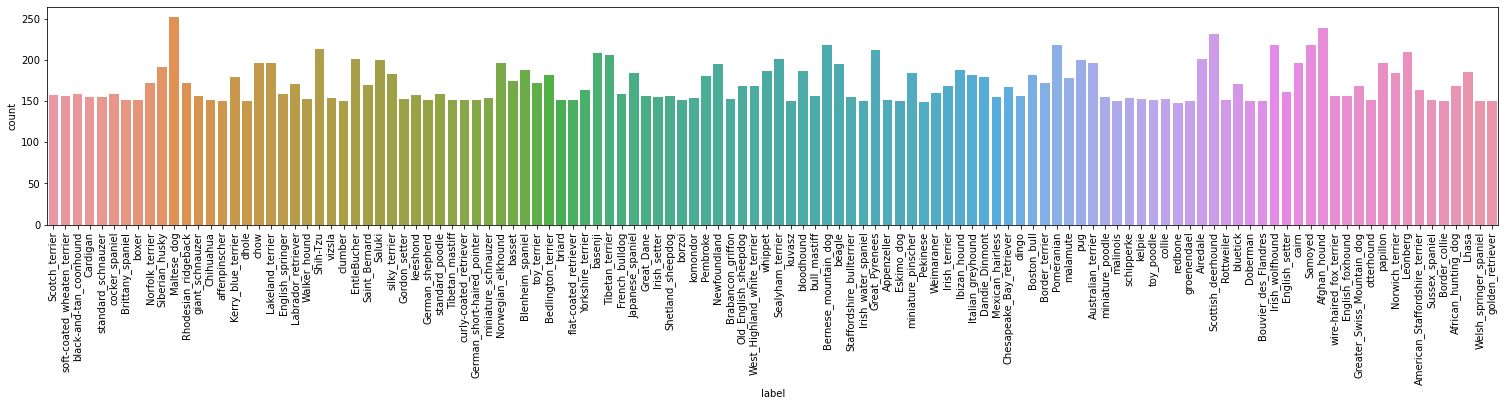

In [39]:
# Check the number of cases by breed in the form of a bar graph
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize=(26, 4))

sns.countplot(data=data_df, x='label')
plt.xticks(rotation=90)

### View Dog Breed's Images

In [40]:
# View Dog Breed's Image
import cv2


def show_grid_images(image_path_list, ncols=6, title=None):
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
    for col in range(ncols):
        image = cv2.cvtColor(cv2.imread(image_path_list[col]), cv2.COLOR_BGR2RGB)
        axs[col].imshow(image)
        axs[col].set_title(title)

Count redbone image:  148


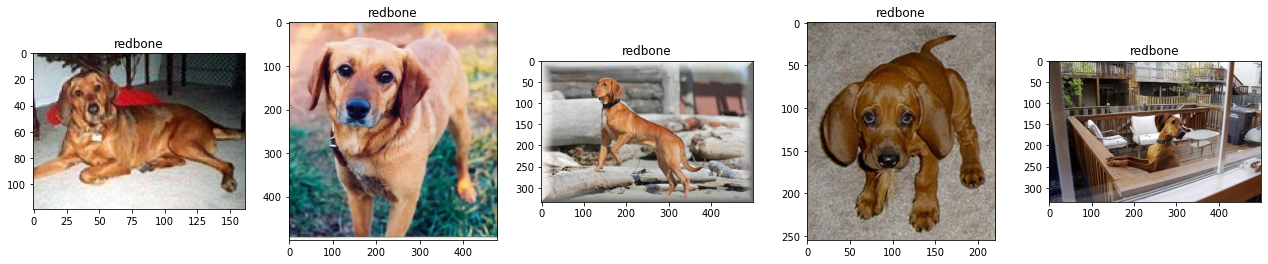

In [49]:
redbone_image_list = data_df[data_df['label']=='redbone']['path'].tolist()
print("Count redbone image: ", len(redbone_image_list))

redbone_image_list = data_df[data_df['label']=='redbone']['path'].iloc[:5].tolist()

show_grid_images(redbone_image_list, ncols=5, title='redbone')

Count Golden Retriever image:  150


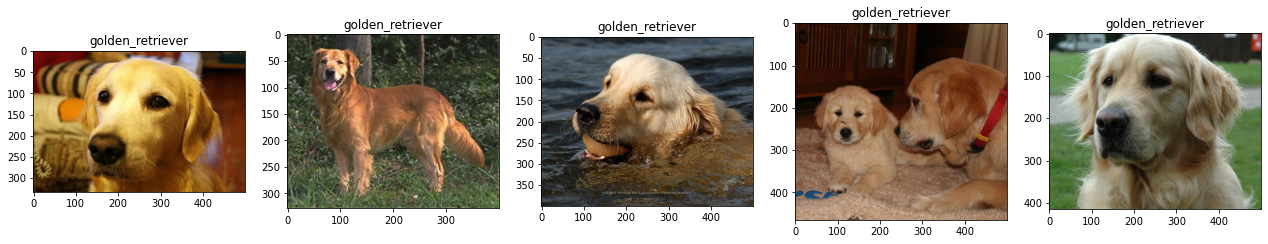

In [51]:
golden_retriever_image_list = data_df[data_df['label']=='golden_retriever']['path'].tolist()
print("Count Golden Retriever image: ", len(golden_retriever_image_list))

golden_retriever_image_list = data_df[data_df['label']=='golden_retriever']['path'].iloc[:5].tolist()

show_grid_images(golden_retriever_image_list, ncols=5, title='golden_retriever')

Count Doberman image:  150


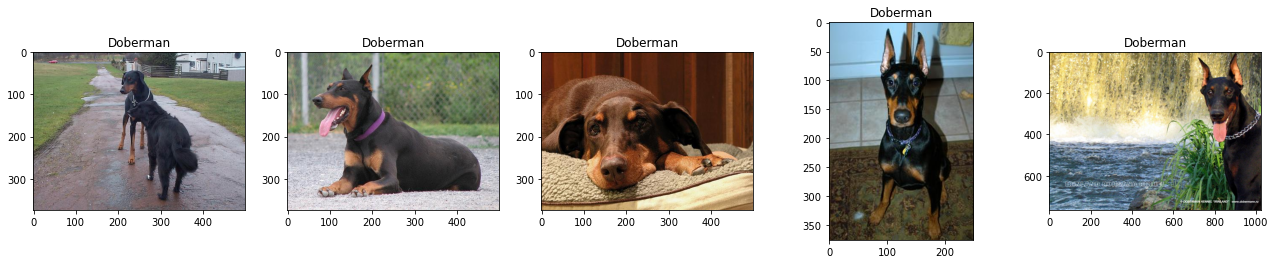

In [52]:
Doberman_image_list = data_df[data_df['label']=='Doberman']['path'].tolist()
print("Count Doberman image: ", len(Doberman_image_list))

Doberman_image_list = data_df[data_df['label']=='Doberman']['path'].iloc[:5].tolist()

show_grid_images(Doberman_image_list, ncols=5, title='Doberman')

***

## Prepare the datasets and generating menifest file

In [11]:
classes_to_be_trained = [
    "n02090379-redbone", 
    "n02099601-golden_retriever", 
    "n02107142-Doberman" 
]

holdoutset_list = {
    "n02090379-redbone" : "./stanford_dog_dataset/images/Images/n02090379-redbone/n02090379_1799.jpg",
    "n02099601-golden_retriever" : "./stanford_dog_dataset/images/Images/n02099601-golden_retriever/n02099601_3388.jpg",
    "n02107142-Doberman" : "./stanford_dog_dataset/images/Images/n02107142-Doberman/n02107142_385.jpg",
    ## the below image is from a new class which is not included as part of the training set
    "n02091831-Saluki" : "./stanford_dog_dataset/images/Images/n02091831-Saluki/n02091831_3909.jpg"
}

In [55]:
dataset_list = []

# Generate trim dataset
makedirs("./stanford_dog_dataset/holdout", exist_ok=True)

for class_nm in classes_to_be_trained:
    new_path = f'./stanford_dog_dataset/dataset/'
    makedirs(new_path, exist_ok=True)
    
    existing_path = f'./stanford_dog_dataset/images/Images/{class_nm}'
    
    onlyfiles = []
    
    for f in listdir(existing_path):
        if isfile(join(existing_path, f)):
            onlyfiles.append(join(existing_path, f))

    onlyfiles.remove(holdoutset_list[class_nm])
    
    for dataset_file_path in onlyfiles:
        dataset_list.append(dataset_file_path)
        dest_dataset_image_path = f'{new_path}/{dataset_file_path.split("/")[-1]}'
        shutil.copy(dataset_file_path, dest_dataset_image_path)

print(dataset_list[0])

./stanford_dog_dataset/images/Images/n02090379-redbone/n02090379_1670.jpg


In [69]:
def generate_manifest_file(stanford_dog_dataset_annotation, final_manifest_file_path):
    final_file = []
    class_dict = {}
    
    for filename in stanford_dog_dataset_annotation:
#         print(filename)
        # Replace Image File Path -> Annotation File Path
        file_path = filename.replace('/images/Images/', '/annotation/Annotation/').replace('.jpg','')
        
        file = open(file_path, mode='r')
        annotation = file.read()
        
        single_file = {}
        
        root = ET.fromstring(annotation)
        
        image_size = {}
        image_nm = None
        
        for child in root:
            if child.tag == 'filename':
                image_nm = child.text # n02085620_10074
            if child.tag == 'size':
                for elem in child.iter():
                    if elem.tag == 'width':
                        image_size['width'] = int(elem.text)
                    if elem.tag == 'height':
                        image_size['height'] = int(elem.text)
                    if elem.tag == 'depth':
                        image_size['depth'] = int(elem.text)
        
        annotations = []
        objects = []
        class_map = {}
        
        object_info = root.findall('object')
        
        for obj in object_info:
            annotation = {}
            confidence = {}
            class_nm = None
            class_id = None
            for elem in obj.iter():
                if elem.tag == 'name':
                    class_nm = elem.text
                    class_id = class_dict.get(class_nm, None)
                    if class_id == None:
                        if len(class_dict) == 0:
                            class_id = 0
                        else:
                            all_values = class_dict.values()
                            max_value = max(all_values)
                            class_id = int(max_value) + 1
                        class_dict[class_nm] = class_id
                
                if elem.tag == 'bndbox':
                    xmin = ymin = xmax = ymax = 0
                    for sub_elem in elem.iter():
                        if sub_elem.tag == 'xmin':
                            xmin = int(sub_elem.text)
                        if sub_elem.tag == 'ymin':
                            ymin = int(sub_elem.text)
                        if sub_elem.tag == 'xmax':
                            xmax = int(sub_elem.text)
                        if sub_elem.tag == 'ymax':
                            ymax = int(sub_elem.text)
                    
                    annotation["class_id"] = class_id
                    annotation["top"] = ymin
                    annotation["left"] = xmin
                    annotation["width"] = xmax - xmin
                    annotation["height"] = ymax - ymin
                    annotations.append(annotation)
                    
                    confidence["confidence"] = 1
                    objects.append(confidence)
                    
                    class_map[class_id] = class_nm
            
        bounding_box = {
            "image_size": [image_size],
            "annotations": annotations
        }
        
        bounding_box_metadata = {
            "objects": objects,
            "class-map": class_map,
            "type": "groundtruth/object-detection",
            "human-annotated": "yes",
            "creation-date": datetime.today().strftime('%Y-%m-%dT%H:%m:%S'),
            "job-name": "testjob"
        }
        
        single_file = {
            "source-ref": f's3://{rek_cl_default_bucket}/stanford_dog_dataset/dataset/{image_nm}.jpg',
            "bounding-box": bounding_box,
            "bounding-box-metadata": bounding_box_metadata
        }
        
        image_json = json.dumps(single_file)
        final_file.append(image_json + "\n")
        file.close()
    
    manifest_file = open(final_manifest_file_path, "w")
    manifest_file.writelines(final_file)
    manifest_file.close()
        

### Generating dataset manifest file

In [70]:
generate_manifest_file(dataset_list, './stanford_dog_dataset/dataset/dataset.manifest')

### Copying the holdout dataset images

In [68]:
for class_nm, file_path in holdoutset_list.items():
    dest_holdout_image_path = f'./stanford_dog_dataset/holdout/{class_nm.split("-")[-1]}.jpg'
    shutil.copy(file_path, dest_holdout_image_path)

### Copy the datasets and holdout set to the Amazon Rekognition Custom Label default S3 bucket

In [71]:
!aws s3 cp ./stanford_dog_dataset/dataset/ s3://$rek_cl_default_bucket/stanford_dog_dataset/dataset/ --recursive --quiet
!aws s3 cp ./stanford_dog_dataset/holdout/ s3://$rek_cl_default_bucket/stanford_dog_dataset/holdout/ --recursive --quiet

***

## Create an Amazon Rekognition Custom Label Project

In [72]:
custom_label_project = rekognition.create_project(
    ProjectName='stanford_dogs_dataset_project'
)

# JSON 형식으로 로드
JSON(custom_label_project)

<IPython.core.display.JSON object>

***

## Import the Datasets into the new Amazon Rekognition Custom Label Project

- Training Dataset
    - A set of labeled or annotated images which will be used to train the model.
    - The model will be trained on this dataset.
- Test Dataset
    - A set of labeled or annotated images which will be used to evaluate the model.

### Create a training dataset using the dataset.menifest file

In [73]:
custom_label_dataset_train = rekognition.create_dataset(
    DatasetSource={
        'GroundTruthManifest': {
            'S3Object': {
                'Bucket': rek_cl_default_bucket,
                'Name': 'stanford_dog_dataset/dataset/dataset.manifest'
            }
        }
    },
    DatasetType='TRAIN',
    ProjectArn=custom_label_project['ProjectArn']
)

JSON(custom_label_dataset_train)

<IPython.core.display.JSON object>

In [74]:
chk_status = True
start_time = time.time()

while chk_status:
    time.sleep(120)
    dataset_status = rekognition.describe_dataset(
        DatasetArn=custom_label_dataset_train['DatasetArn']
    )
    
    if dataset_status['DatasetDescription']['Status'] != 'CREATE_IN_PROGRESS':
        chk_status = False
    
    if (time.time() - start_time) > 3600:
        chk_status = False

JSON(dataset_status)

<IPython.core.display.JSON object>

### Create an empty test dataset
- As we will use the distribute dataset api later to keep aside 20% of training data for the training dataset

In [75]:
custom_label_dataset_test = rekognition.create_dataset(
    DatasetType='TEST',
    ProjectArn=custom_label_project['ProjectArn']
)

JSON(custom_label_dataset_test)

<IPython.core.display.JSON object>

In [76]:
chk_status = True
start_time = time.time()

while chk_status:
    time.sleep(120)
    dataset_status = rekognition.describe_dataset(
        DatasetArn=custom_label_dataset_test['DatasetArn']
    )
    
    if dataset_status['DatasetDescription']['Status'] != 'CREATE_IN_PROGRESS':
        chk_status = False
    if (time.time() - start_time) > 3600:
        chk_status = False

JSON(dataset_status)

<IPython.core.display.JSON object>

### Split the dataset into Training and Test datasets using Rekognition Custom Label API

In [77]:
custom_label_distribute_dataset = rekognition.distribute_dataset_entries(
    Datasets=[
        {
            'Arn': custom_label_dataset_train['DatasetArn']
        },
        {
            'Arn': custom_label_dataset_test['DatasetArn']
        }
    ]
)

In [78]:
chk_status = True
start_time = time.time()

while chk_status:
    time.sleep(120)
    dataset_status_train = rekognition.describe_dataset(
        DatasetArn=custom_label_dataset_train['DatasetArn']
    )
    dataset_status_test = rekognition.describe_dataset(
        DatasetArn=custom_label_dataset_test['DatasetArn']
    )
    
    if (dataset_status_train['DatasetDescription']['Status'] != 'CREATE_IN_PROGRESS') and \
        (dataset_status_test['DatasetDescription']['Status'] != 'CREATE_IN_PROGRESS'):
        chk_status = False
    if (time.time() - start_time) > 3600:
        chk_status = False

JSON(dataset_status_train)

<IPython.core.display.JSON object>

***

## Train a Custom Model to detect Dog breed

### Start Training the model

In [81]:
model_version_name = f"model_v{str(int(time.time()))}"

custom_label_train_model = rekognition.create_project_version(
    ProjectArn=custom_label_project['ProjectArn'],
    VersionName=model_version_name,
    OutputConfig={
        'S3Bucket': rek_cl_default_bucket,
        'S3KeyPrefix': 'stanford_dog_dataset/model_train'
    }
)
JSON(custom_label_train_model)

<IPython.core.display.JSON object>

In [ ]:
chk_status = True
start_time = time.time()

while chk_status:
    time.sleep(1800)
    model_training_status = rekognition.describe_project_versions(
        ProjectArn=custom_label_project['ProjectArn'],
        VersionNames=[
            model_version_name
        ]
    )
    
    if model_training_status['ProjectVersionDescriptions'][0]['Status'] != 'TRAINING_IN_PROGRESS':
        chk_status = False
    if (time.time() - start_time) > 36000:
        chk_status = False

JSON(model_training_status)

### Retrieve the Model Metrics

In [84]:
model_metrics = rekognition.describe_project_versions(
    ProjectArn=custom_label_project['ProjectArn'],
    VersionNames=[
        model_version_name
    ]
)

# model_metrics

print("F1 Score " + str(model_metrics['ProjectVersionDescriptions'][0]['EvaluationResult']['F1Score']))

s3_resource = boto3.resource('s3')
content_object = s3_resource.Object(
    model_metrics['ProjectVersionDescriptions'][0]['EvaluationResult']['Summary']['S3Object']['Bucket'],
    model_metrics['ProjectVersionDescriptions'][0]['EvaluationResult']['Summary']['S3Object']['Name']
)

file_content = content_object.get()['Body'].read().decode('utf-8')
json_content = json.loads(file_content)

JSON(json_content)

F1 Score 0.9703547954559326


<IPython.core.display.JSON object>

***

## Start the trained model

In [85]:
start_model = rekognition.start_project_version(
    ProjectVersionArn=model_metrics['ProjectVersionDescriptions'][0]['ProjectVersionArn'],
    MinInferenceUnits=1
)

JSON(start_model)

<IPython.core.display.JSON object>

In [86]:
chk_status = True
start_time = time.time()

while chk_status:
    time.sleep(300)
    model_start_status = rekognition.describe_project_versions(
        ProjectArn=custom_label_project['ProjectArn'],
        VersionNames=[
            model_version_name
        ]
    )
    
    if model_start_status['ProjectVersionDescriptions'][0]['Status'] != 'STARTING':
        chk_status = False
    if (time.time() - start_time) > 3600:
        chk_status = False

***

## Run tests on the holdout images

In [88]:
import boto3
import io
import logging
from PIL import Image, ImageDraw, ImageFont
from IPython.display import HTML, display

from botocore.exceptions import ClientError

logger = logging.getLogger(__name__)

def analyze_s3_image(rek_client, s3_connection, model, bucket, photo, min_confidence):
    """
    Analyzes an image stored in the specified S3 bucket.
    :param rek_client: The Amazon Rekognition Boto3 client.
    :param s3_connection: The Amazon S3 Boto3 S3 connection object.
    :param model: The ARN of the Amazon Rekognition Custom Labels model that you want to use.
    :param bucket: The name of the S3 bucket that contains the image that you want to analyze.
    :param photo: The name of the photo that you want to analyze.
    :param min_confidence: The desired threshold/confidence for the call.
    """
    
    try:
        logger.info("analyzing bucket: %s image: %s", bucket, photo)
        s3_object = s3_connection.Object(bucket, photo)
        s3_response = s3_object.get()
        
        stream = io.BytesIO(s3_response['Body'].read())
        image=Image.open(stream)
        
        image_type=Image.MIME[image.format]
        
        if (image_type == 'image/jpeg' or image_type == 'image/png') == False:
            logger.error("Invalid image type for %s", photo)
            raise ValueError(
                f"Invalid file format. Supply a jpeg or png format file: {photo}"
            )
        
        img_width, img_height = image.size
        draw = ImageDraw.Draw(image)
        
        # Call DetectCustomLabels
        response = rek_client.detect_custom_labels(
            Image={
                "S3Object":
                {
                    "Bucket": bucket,
                    "Name": photo
                }
            },
            MinConfidence=min_confidence,
            ProjectVersionArn=model
        )
        
        show_image(image, response)
        
        return len(response['CustomLabels'])
    
    except ClientError as err:
        logger.error(format(err))
        raise

def show_image(image, response):
    """
    Displays the analyzed image and overlays analysis results
    :param image: The analyzed image
    :param response: the response from DetectCustomLabels
    """
    try:
        font_size=10
        line_width=5
        
        img_width, img_height = image.size
        draw = ImageDraw.Draw(image)
        
        # calculate and display bounding boxes for each detected custom label
        image_level_label_height = 0
        
        for custom_label in response['CustomLabels']:
            confidence = int(round(custom_label['Confidence'], 0))
            label_text = f"{custom_label['Name']}:{confidence}%"
            fnt = ImageFont.truetype("/usr/share/fonts/dejavu/DejaVuSans.ttf", font_size)
            text_width, text_height = draw.textsize(label_text, fnt)
            
            logger.info(f"Label: {custom_label['Name']}")
            logger.info(f"Confidence: {confidence}%")
            
            # Draw bounding boxex, if present
            if 'Geometry' in custom_label:
                box = custom_label['Geometry']['BoundingBox']
                left = img_width * box['Left']
                top = img_height * box['Top']
                width = img_width * box['Width']
                height = img_height * box['Height']
                
                logger.info("Bounding box")
                logger.info("\tLeft: {0:.0f}".format(left))
                logger.info("\tTop: {0:.0f}".format(top))
                logger.info("\tLabel Width: {0:.0f}".format(width))
                logger.info("\tLabel Height: {0:.0f}".format(height))
                
                points = (
                    (left,top),
                    (left + width, top),
                    (left + width, top + height),
                    (left , top + height),
                    (left, top))
                
                #Draw bounding box and label text
                draw.line(points, fill="limegreen", width=line_width)
                draw.rectangle([(left + line_width , top+line_width), (left + text_width + line_width, top + line_width + text_height)],fill="black")
                draw.text((left + line_width ,top +line_width), label_text, fill="limegreen", font=fnt)
            
            #draw image-level label text.
            else:
                draw.rectangle([(10 , image_level_label_height), (text_width + 10, image_level_label_height+text_height)],fill="black")
                draw.text((10,image_level_label_height), label_text, fill="limegreen", font=fnt)  

                image_level_label_height += text_height
            
#         image.show()
        display(image)

    except Exception as err:
        logger.error(format(err))
        raise
        
def analyze_rekcl_bb(bckt_nm, pics, modelarn, minconfdnce):
    
    try:
        logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

        bucket=bckt_nm
        photos=pics
        model=modelarn
        min_confidence=minconfdnce
       

        rek_client=boto3.client('rekognition')
        
        s3_connection = boto3.resource('s3')
        for photo in photos:
            label_count=analyze_s3_image(rek_client,
                s3_connection,
                model,
                bucket,
                photo,
                min_confidence)
            
            
            
            

        """
        # Uncomment to analyze a local file. 
        # Change photo to the path and file name of a local file.
        label_count=analyze_local_image(rek_client,
            model,
            photo,
            min_confidence)
        
        """ 
        logger.info(f"Custom labels detected: {label_count}")

    except ClientError as err:
        print("A service client error occurred: " + format(err.response["Error"]["Message"]))
    except ValueError as err:
        print ("A value error occurred: " + format(err))

***

## Test the model on the holdout dataset

INFO: analyzing bucket: custom-labels-console-ap-northeast-2-848d0c39c9 image: stanford_dog_dataset/holdout/Saluki.jpg


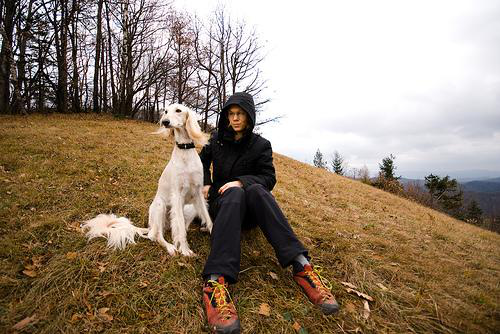

INFO: analyzing bucket: custom-labels-console-ap-northeast-2-848d0c39c9 image: stanford_dog_dataset/holdout/Doberman.jpg
INFO: Label: Doberman
INFO: Confidence: 100%
INFO: Bounding box
INFO: 	Left: 12
INFO: 	Top: 9
INFO: 	Label Width: 330
INFO: 	Label Height: 254


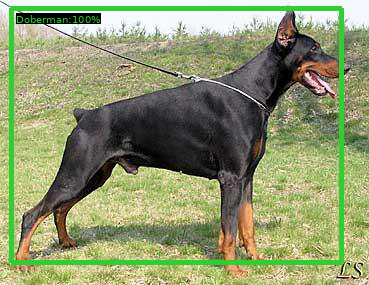

INFO: analyzing bucket: custom-labels-console-ap-northeast-2-848d0c39c9 image: stanford_dog_dataset/holdout/redbone.jpg
INFO: Label: redbone
INFO: Confidence: 100%
INFO: Bounding box
INFO: 	Left: 134
INFO: 	Top: 11
INFO: 	Label Width: 210
INFO: 	Label Height: 363


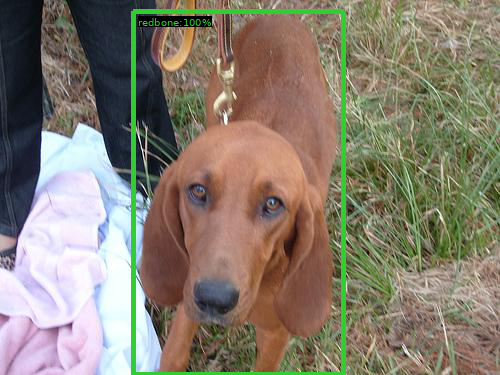

INFO: analyzing bucket: custom-labels-console-ap-northeast-2-848d0c39c9 image: stanford_dog_dataset/holdout/golden_retriever.jpg
INFO: Label: golden_retriever
INFO: Confidence: 100%
INFO: Bounding box
INFO: 	Left: 103
INFO: 	Top: 1
INFO: 	Label Width: 278
INFO: 	Label Height: 331


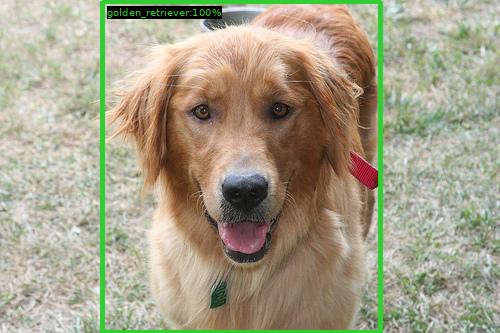

INFO: Custom labels detected: 1


In [89]:
bucket_nm = rek_cl_default_bucket

holdout_photos = []

for f in listdir('./stanford_dog_dataset/holdout'):
    if (isfile(join('./stanford_dog_dataset/holdout', f)) and (f.split(".")[-1]) == 'jpg'):
        holdout_photos.append(('stanford_dog_dataset/holdout/' + f))

model_arn = model_metrics['ProjectVersionDescriptions'][0]['ProjectVersionArn']
min_confidence = 70

analyze_rekcl_bb(bucket_nm, holdout_photos, model_arn, min_confidence)

***

## Stop the trained model

In [90]:
stop_model = rekognition.stop_project_version(
    ProjectVersionArn=model_metrics['ProjectVersionDescriptions'][0]['ProjectVersionArn']
)

JSON(stop_model)

<IPython.core.display.JSON object>

In [91]:
chk_status = True
start_time = time.time()

while chk_status:
    time.sleep(300)
    model_stop_status = rekognition.describe_project_versions(
        ProjectArn=custom_label_project['ProjectArn'],
        VersionNames=[
            model_version_name
        ]
    )
    
    if model_stop_status['ProjectVersionDescriptions'][0]['Status'] != 'STOPPING':
        chk_status = False
    if (time.time() - start_time) > 3600:
        chk_status = False

JSON(model_stop_status)

<IPython.core.display.JSON object>